<a href="https://colab.research.google.com/github/taylsonmartinez/main_portfolio/blob/master/Suporte_e_Resist%C3%AAncias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando as bibliotecas e baixando os dados necessárias

In [1]:
!pip install -q yfinance
import yfinance as yf
!pip install --upgrade -q mplfinance
import mplfinance as mpf

     |████████████████████████████████| 6.4 MB 6.1 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 64 kB 1.8 MB/s 


Baixaremos os dados de PETR4 a partir do início do ano até o último pregão.



In [2]:
ticker = 'PETR4.SA'
start = '2021-01-01'
end = '2022-01-30'
df = yf.download(ticker, start, end)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,28.650000,29.180000,28.530001,28.910000,23.497818,74719700
2021-01-05,28.900000,30.180000,28.240000,30.040001,24.416273,95181100
2021-01-06,30.160000,30.900000,30.049999,30.100000,24.465040,96562500
2021-01-07,30.340000,31.150000,30.340000,31.000000,25.196552,56171300
2021-01-08,31.459999,31.760000,30.350000,31.120001,25.294088,67136300
...,...,...,...,...,...,...
2022-01-24,31.690001,32.250000,31.040001,31.950001,31.950001,79117100
2022-01-25,31.700001,33.230000,31.580000,32.990002,32.990002,98358500
2022-01-26,33.299999,34.270000,33.299999,33.869999,33.869999,98679900


# Criando as funções que identificarão os fractais


In [3]:
def is_resistance(df,i):
  support = (df['High'][i] > df['High'][i-1]
             and df['High'][i] > df['High'][i+1]
             and df['High'][i+1] > df['High'][i+2]
             and df['High'][i-1] > df['High'][i-2])
  return support

def is_support(df,i):
  support = (df['Low'][i] < df['Low'][i-1]
             and df['Low'][i] < df['Low'][i+1]
             and df['Low'][i+1] < df['Low'][i+2]
             and df['Low'][i-1] < df['Low'][i-2])
  return support

In [4]:
# coordinates is a list of a list of two tuples
# the first tuple has the signal candle's index as 1st argument and the price as 2nd
# the second tuple has the last index as 1st argument in order to draw the support/resistance 
# line till the end of the graph 

coordinates = []
for i in range(2, df.shape[0] - 2):
  if is_support(df, i):
    coordinates.append([
      (df.index[i], df['Low'][i]), # If support, plot a horizontal line from the low
      (max(df.index),df['Low'][i])
    ])
  elif is_resistance(df, i):
    coordinates.append([
      (df.index[i],df['High'][i]), # If resistance, plot a horizontal line from the high
      (max(df.index),df['High'][i])
    ])

coordinates[:5]

[[(Timestamp('2021-01-20 00:00:00'), 29.1200008392334),
  (Timestamp('2022-01-28 00:00:00'), 29.1200008392334)],
 [(Timestamp('2021-02-18 00:00:00'), 30.920000076293945),
  (Timestamp('2022-01-28 00:00:00'), 30.920000076293945)],
 [(Timestamp('2021-02-22 00:00:00'), 21.399999618530273),
  (Timestamp('2022-01-28 00:00:00'), 21.399999618530273)],
 [(Timestamp('2021-02-25 00:00:00'), 25.25),
  (Timestamp('2022-01-28 00:00:00'), 25.25)],
 [(Timestamp('2021-03-03 00:00:00'), 20.479999542236328),
  (Timestamp('2022-01-28 00:00:00'), 20.479999542236328)]]

# Plotando o gráfico com os suportes e resistências


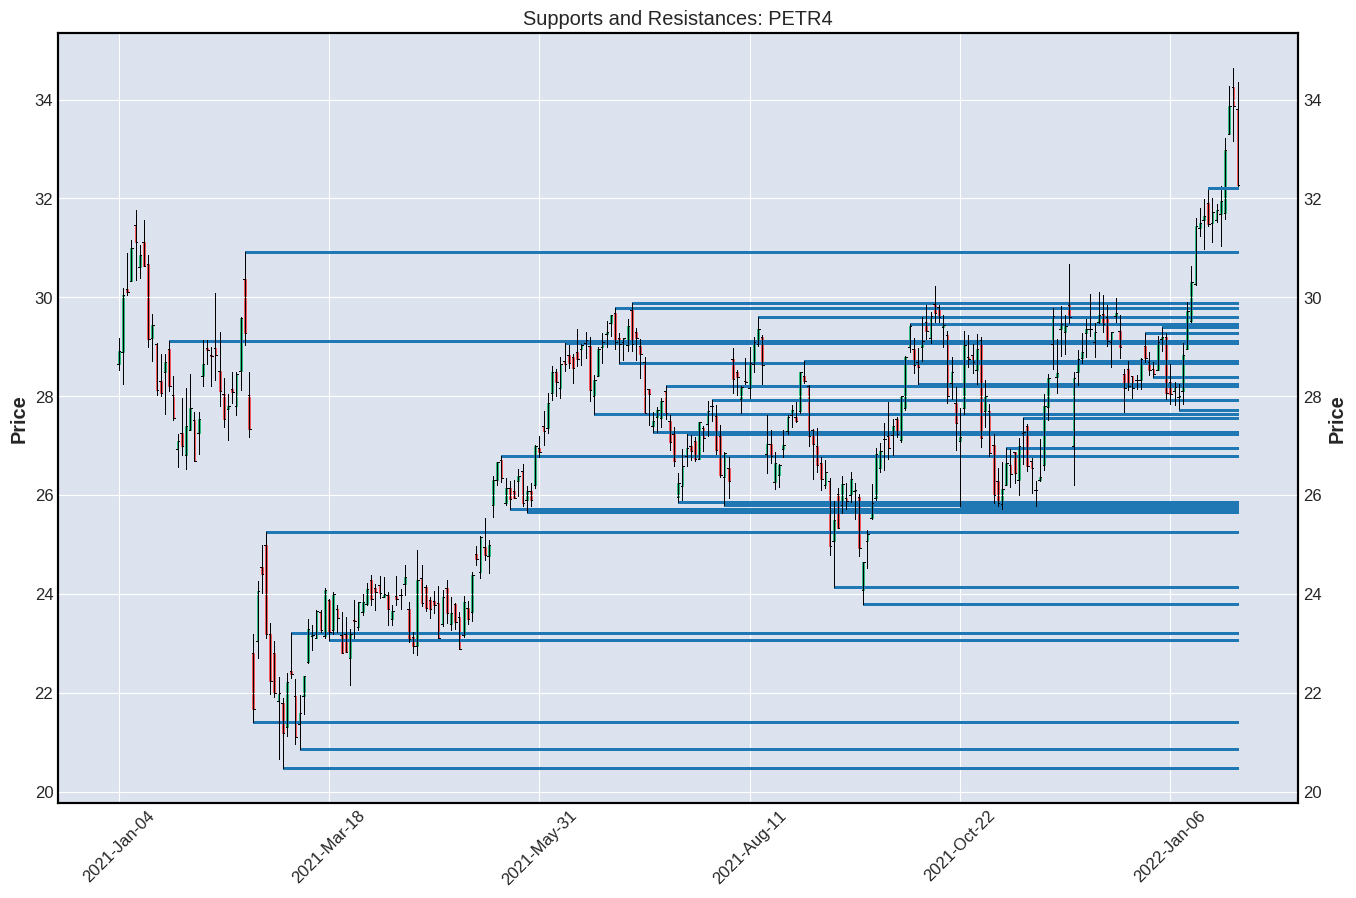

In [5]:
def plot_all(coordinates):

  fig = mpf.figure(figsize=(16, 10))
  title = f"Supports and Resistances: {ticker.replace('.SA', '')}"
  ax1 = fig.subplot(title=title)
  ax2 = ax1.twinx()

  mpf.plot(df,
           ax=ax1,
           style='yahoo',
           type='candle',
           ylabel='Price')

  for coordinate in coordinates:
    mpf.plot(df, alines=(coordinate), ax=ax2)

plot_all(coordinates)

Refinando o nosso gráfico


In [6]:
import numpy as np
avg_candle_size =  np.mean(df['High'] - df['Low'])
avg_candle_size

0.8490636161204135

In [7]:
def is_far_from_level(price, levels, delta):
    is_far = True
    for level in levels:
        if (abs(level - price) < delta):
            is_far = False
            break
    return is_far

In [8]:
no_noise_levels = []
coordinates = []

# We skip the first and the last 2 data points once we need at least 5 candles
# to form the patter
for i in range(2, df.shape[0] - 2):

    if is_support(df, i):
        price = df['Low'][i]
        if is_far_from_level(price, no_noise_levels, avg_candle_size):
            no_noise_levels.append(price)
            coordinates.append([
                (df.index[i], price), (max(df.index), price)
            ])
            
    elif is_resistance(df,i):
        price = df['High'][i]
        if is_far_from_level(price, no_noise_levels, avg_candle_size):
            no_noise_levels.append(price)
            coordinates.append([
                (df.index[i], price), (max(df.index), price)
            ])

coordinates

[[(Timestamp('2021-01-20 00:00:00'), 29.1200008392334),
  (Timestamp('2022-01-28 00:00:00'), 29.1200008392334)],
 [(Timestamp('2021-02-18 00:00:00'), 30.920000076293945),
  (Timestamp('2022-01-28 00:00:00'), 30.920000076293945)],
 [(Timestamp('2021-02-22 00:00:00'), 21.399999618530273),
  (Timestamp('2022-01-28 00:00:00'), 21.399999618530273)],
 [(Timestamp('2021-02-25 00:00:00'), 25.25),
  (Timestamp('2022-01-28 00:00:00'), 25.25)],
 [(Timestamp('2021-03-03 00:00:00'), 20.479999542236328),
  (Timestamp('2022-01-28 00:00:00'), 20.479999542236328)],
 [(Timestamp('2021-03-05 00:00:00'), 23.219999313354492),
  (Timestamp('2022-01-28 00:00:00'), 23.219999313354492)],
 [(Timestamp('2021-05-18 00:00:00'), 26.799999237060547),
  (Timestamp('2022-01-28 00:00:00'), 26.799999237060547)],
 [(Timestamp('2021-07-14 00:00:00'), 28.200000762939453),
  (Timestamp('2022-01-28 00:00:00'), 28.200000762939453)],
 [(Timestamp('2021-09-09 00:00:00'), 24.139999389648438),
  (Timestamp('2022-01-28 00:00:00'),

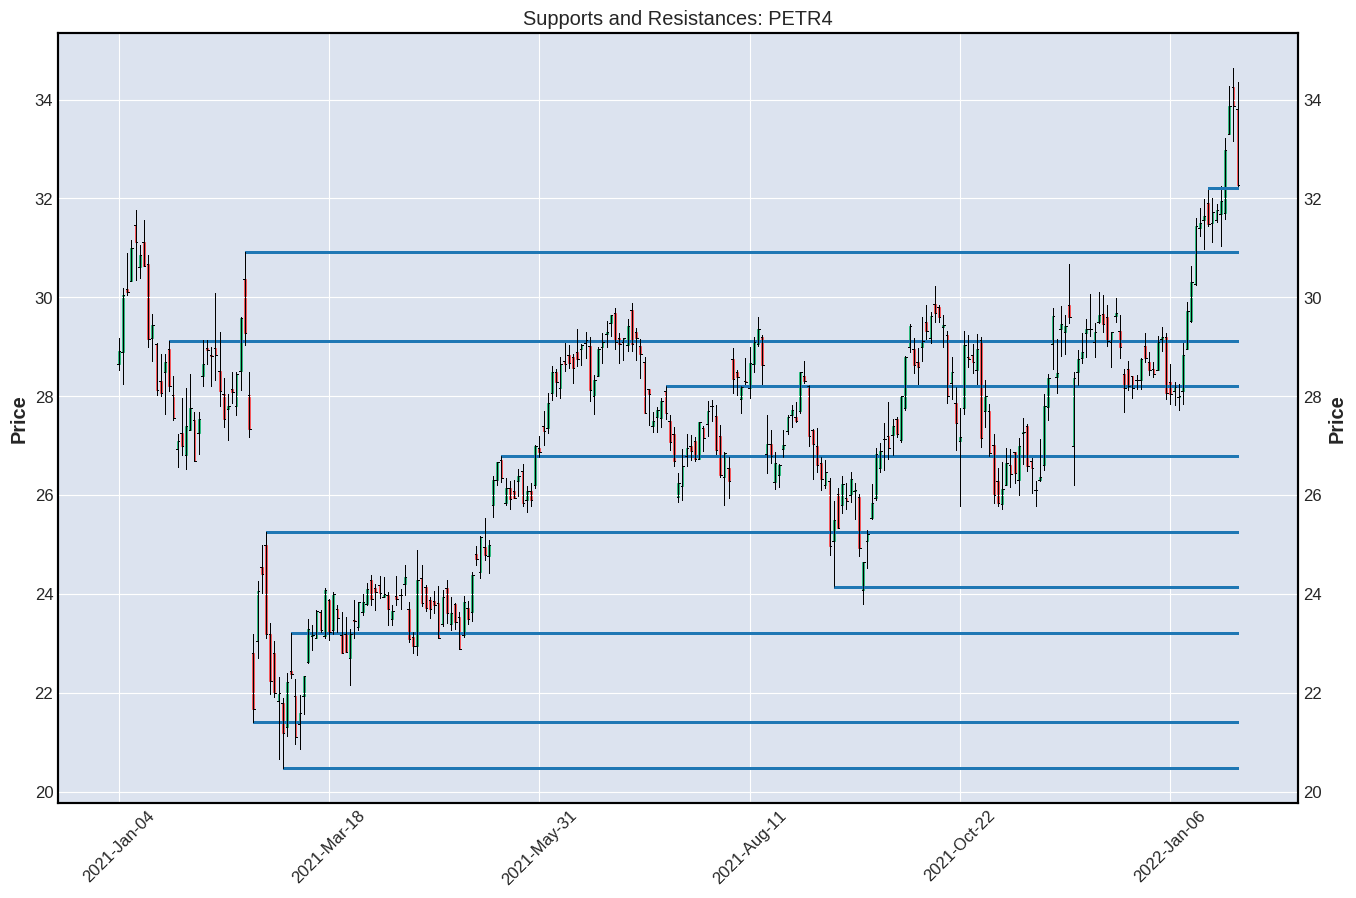

In [9]:
plot_all(coordinates)
